In [1]:
import pandas as pd


In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/dataset-for-problem2/dataset_for_problem2.csv')

In [3]:
# Step 2: Explore the Dataset
print("Dataset Columns:")
print(df.columns.tolist())
print("\nDataset Info:")
print(df.info())
print("\nFirst Few Rows:")
print(df.head())

# Step 3: Print Data Types of Each Column
print("\nData Types of Each Column:")
print(df.dtypes)

Dataset Columns:
['code', 'week', 'feature', 'display', 'province', 'feature_encoded', 'display_encoded', 'type', 'brand', 'size', 'size_in_grams', 'type_encoded', 'brand_category', 'size_in_grams_scaled', 'supermarket_No', 'postal-code']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350176 entries, 0 to 350175
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   code                  350176 non-null  int64  
 1   week                  350176 non-null  int64  
 2   feature               350176 non-null  object 
 3   display               350176 non-null  object 
 4   province              350176 non-null  int64  
 5   feature_encoded       350176 non-null  int64  
 6   display_encoded       350176 non-null  int64  
 7   type                  350176 non-null  object 
 8   brand                 350176 non-null  object 
 9   size                  350176 non-null  object 
 10  size_i

In [4]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f'Total duplicates: {duplicate_count}')


Total duplicates: 0


**Model Development**

In [5]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint  # Import randint from scipy.stats
from sklearn.model_selection import RandomizedSearchCV

In [6]:
#number of rows in the dataset
print(len(df))

350176


In [7]:
# Sample 50% of the data
df = df.sample(frac=0.75, random_state=42)

In [8]:
print(len(df))

262632


In [9]:
# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['size_in_grams_scaled'].quantile(0.25)
Q3 = df['size_in_grams_scaled'].quantile(0.75)

# Step 2: Calculate IQR
IQR = Q3 - Q1

# Step 3: Determine bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Filter out outliers
df = df[(df['size_in_grams_scaled'] >= lower_bound) & (df['size_in_grams_scaled'] <= upper_bound)]

In [10]:
# Create Target Variable Based on Promotion Frequency
promotion_frequency = df.groupby('code').size().reset_index(name='promotion_count')
df = df.merge(promotion_frequency, on='code', how='left')

In [11]:
# Define 'effective' as 1 if the promotion count is above the average, else 0
average_promotions = df['promotion_count'].mean()
df['effective'] = (df['promotion_count'] > average_promotions).astype(int)

In [12]:
#Convert 'province' and 'brand_category' to categorical data type
df['province'] = df['province'].astype('category')
df['brand_category'] = df['brand_category'].astype('category')

#Initialize LabelEncoder
label_encoder = LabelEncoder()

#Encode 'province'
df['province_encoded'] = label_encoder.fit_transform(df['province'])

# Encode 'brand_category'
df['brand_category_encoded'] = label_encoder.fit_transform(df['brand_category'])


In [13]:
# Define features and target variable
X = df.drop(columns=['effective', 'code', 'supermarket_No', 'postal-code', 'promotion_count','feature','display','type','brand','size','size_in_grams','brand_category','province'])
y = df['effective']

In [14]:
# Split the dataset into training and testing sets (50% for both)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Print the columns used to train the model
print("Columns used to train the model:")
print(X_train.columns.tolist())

Columns used to train the model:
['week', 'feature_encoded', 'display_encoded', 'type_encoded', 'size_in_grams_scaled', 'province_encoded', 'brand_category_encoded']


In [16]:
# Print the data types of columns used to train the model
print("Data types of columns used to train the model:")
print(X_train.dtypes)

Data types of columns used to train the model:
week                        int64
feature_encoded             int64
display_encoded             int64
type_encoded                int64
size_in_grams_scaled      float64
province_encoded            int64
brand_category_encoded      int64
dtype: object


In [17]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)


In [18]:
#Define the parameter grid
param_dist = {
    'n_estimators': randint(50, 500),  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],   # Number of features to consider at every split
    'max_depth': randint(10, 50),       # Maximum number of levels in tree
    'min_samples_split': randint(2, 20), # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20)  # Minimum number of samples required to be at a leaf node
}

In [19]:
#Create RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, 
                                   n_iter=100,  # Number of iterations
                                   scoring='accuracy', # Evaluation metric
                                   cv=3, # Number of cross-validation folds
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)  # Use all available cores

In [20]:
#Fit the model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cbaf9c07220>,
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cbaf9c54e80>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cbaf9c07cd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cbaf9c07820>},
                   random_state=42, scoring='accuracy', verbose=1)

In [21]:
#Output the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'max_depth': 46, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 148}
Best Score: 0.8941008507256188


In [22]:
#Optionally, evaluate the model on the test set
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Set Accuracy:", test_accuracy)

Test Set Accuracy: 0.8971485762505642


In [23]:
# Make predictions with the best model
y_pred = best_model.predict(X_test)

In [24]:
# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[22739  3387]
 [ 1854 22977]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     26126
           1       0.87      0.93      0.90     24831

    accuracy                           0.90     50957
   macro avg       0.90      0.90      0.90     50957
weighted avg       0.90      0.90      0.90     50957



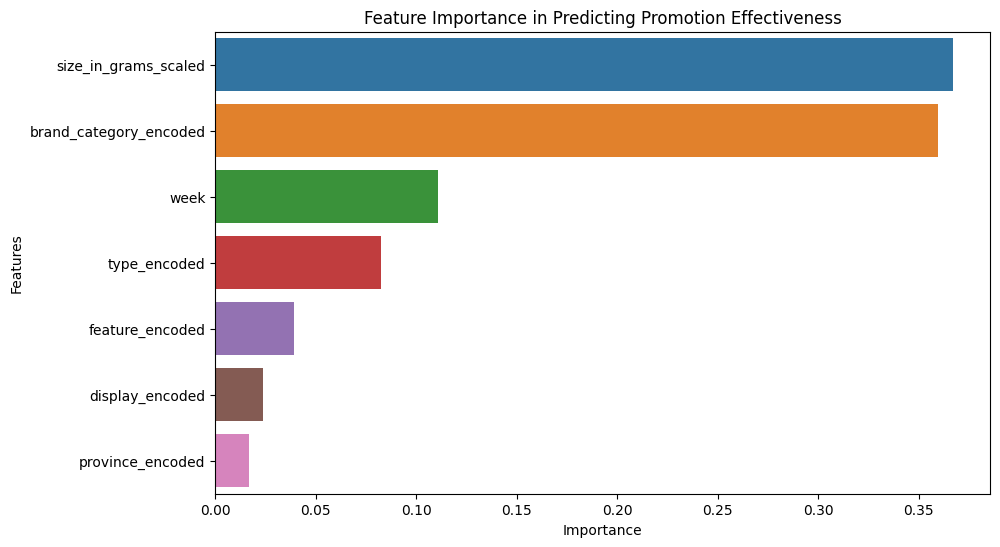

In [25]:
# Feature Importance Analysis
feature_importances = best_model.feature_importances_  # Use best_model
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance in Predicting Promotion Effectiveness')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

<ipython-input-26-467ed96940a3>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  popularity_by_location = predictions_df.groupby(['province']).agg(
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


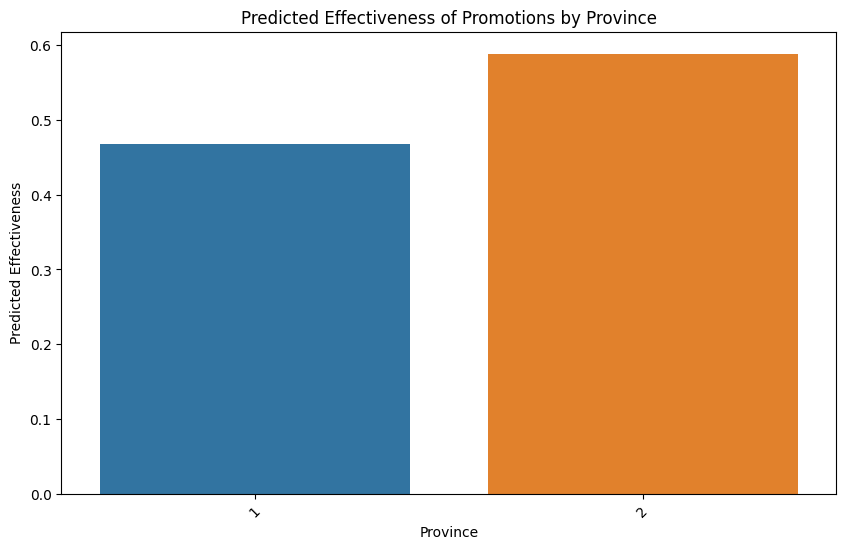

In [26]:
# Insight 2: Item Popularity by Location
# Create a DataFrame with predictions and actual effectiveness
predictions_df = X_test.copy()
predictions_df['actual'] = y_test
predictions_df['predicted'] = best_model.predict(X_test)  # Use best_model for predictions
predictions_df['province'] = df.loc[X_test.index, 'province']

# Calculate effectiveness by province
popularity_by_location = predictions_df.groupby(['province']).agg(
    actual_effectiveness=('actual', 'mean'),
    predicted_effectiveness=('predicted', 'mean')
).reset_index()

# Plot popularity by location
plt.figure(figsize=(10, 6))
sns.barplot(data=popularity_by_location, x='province', y='predicted_effectiveness')
plt.title('Predicted Effectiveness of Promotions by Province')
plt.xlabel('Province')
plt.ylabel('Predicted Effectiveness')
plt.xticks(rotation=45)
plt.show()


In [27]:
# Display the insights
print("\nBusiness Insight 1: Feature Importance Analysis")
print(importance_df)

print("\nBusiness Insight 2: Item Popularity by Location")
print(popularity_by_location)


Business Insight 1: Feature Importance Analysis
                  Feature  Importance
4    size_in_grams_scaled    0.367380
6  brand_category_encoded    0.359510
0                    week    0.110747
3            type_encoded    0.082607
1         feature_encoded    0.039037
2         display_encoded    0.023853
5        province_encoded    0.016866

Business Insight 2: Item Popularity by Location
  province  actual_effectiveness  predicted_effectiveness
0        1              0.468112                 0.467377
1        2              0.514602                 0.588565
